### _imports_

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np

from IPython.display import display

import xml.etree.ElementTree as ET

import warnings
warnings.filterwarnings('ignore')

# 1. Kaggle

In [2]:
pd.set_option('display.max_columns', None)
shelter_df = pd.read_csv('train.csv');

## 1.1 Cats vs dogs

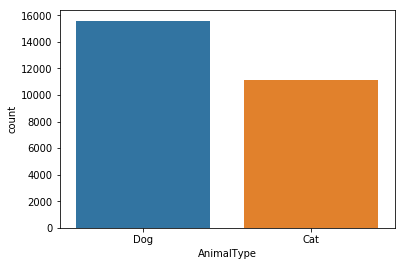

In [3]:
sns.countplot(x='AnimalType', data=shelter_df);

## 1.2 OutcomeType

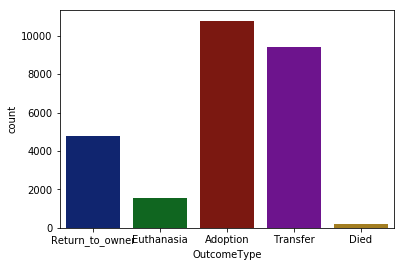

In [4]:
sns.countplot(x='OutcomeType', data=shelter_df, palette='dark');

##  1.3 SexuponOutcome vs OutcomeType

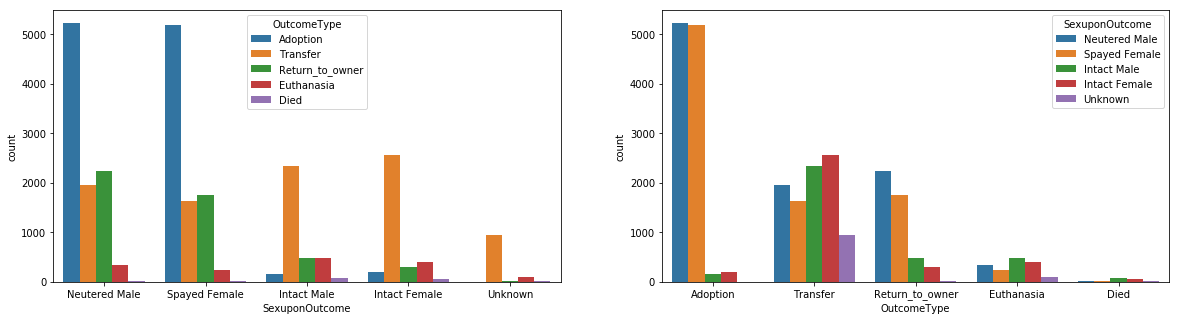

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.countplot(ax=axes[0], data=shelter_df,
              x='SexuponOutcome', hue='OutcomeType', 
              order=shelter_df['SexuponOutcome'].value_counts().index,
              hue_order=shelter_df['OutcomeType'].value_counts().index)
sns.countplot(ax=axes[1], data=shelter_df, 
              x='OutcomeType', hue='SexuponOutcome',
              order=shelter_df['OutcomeType'].value_counts().index,
              hue_order=shelter_df['SexuponOutcome'].value_counts().index);

## 1.4 AnimalType vs OutcomeType

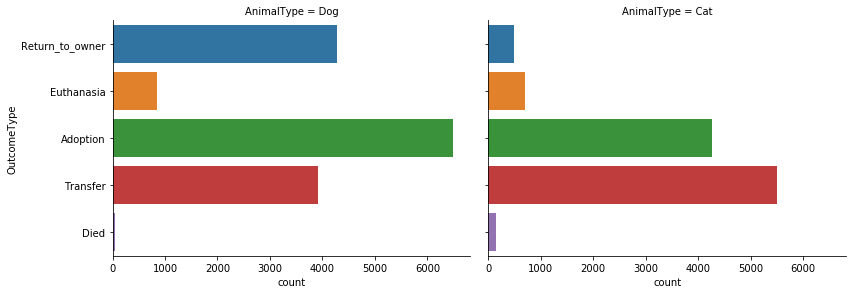

In [6]:
sns.factorplot(y='OutcomeType', col='AnimalType', data=shelter_df, kind='count', size=4, aspect=1.5);

## 1.5 Mix

**\* ** _у меня есть предположение, что должен быть какой-то более простой способ, чтобы как посчитать, так и вывести на график относительное число элементов по категориям, но на данном этапе смог сделать только так)._

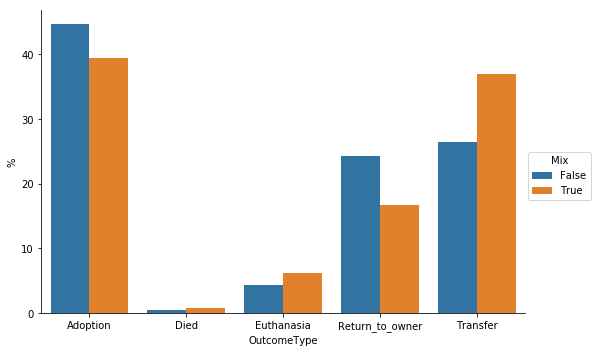

In [7]:
# Добавляем признак смешанной породы 'Mix'
shelter_df['Mix'] = shelter_df['Breed'].str.lower().str.contains('mix')

# Относительное количество OutcomeType по признаку смешанности породы
mix_out_ratios = shelter_df.groupby(['OutcomeType', 'Mix'])['Mix'].count()
mix_out_ratios = mix_out_ratios.groupby(level=1).apply(lambda x: x / sum(x))
# В процентах
mix_out_ratios_df = (mix_out_ratios * 100).reset_index(name = '%')

# как можно видеть, факт смешанной породы мало связян c OutcomeType
sns.factorplot(data=mix_out_ratios_df, kind='bar', x='OutcomeType', y='%', hue='Mix', size=5, aspect=1.5);

## 1.6 AgeInYears

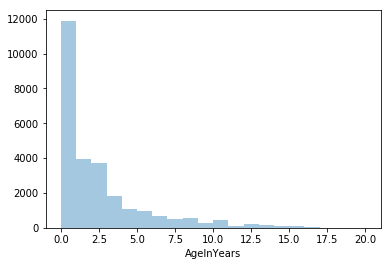

In [8]:
def translate_age(s):
    if not type(s) is str:
        return s
    days_factor = {'year' : 365, 'years' : 365, 'month' : 30, 'months' : 30, 'week' : 7, 'weeks' : 7, 'day' : 1, 'days' : 1}
    s = s.split()
    return int(s[0]) * days_factor[s[1]] / 365

shelter_df['AgeInYears'] = shelter_df['AgeuponOutcome'].apply(translate_age)

sns.distplot(shelter_df['AgeInYears'].dropna(), bins=20, kde=False);

## 1.7 Age groups

AgeGroup,<3 лет,3-5 лет,5-10 лет,>10 лет
OutcomeType,,,,
Adoption,44.293658,32.550104,30.096122,19.474117
Died,0.862201,0.276434,0.265164,0.986031
Euthanasia,4.234478,7.567381,9.181306,18.816763
Return_to_owner,11.030049,33.828611,37.686443,41.741988
Transfer,39.579613,25.777471,22.770965,18.981101


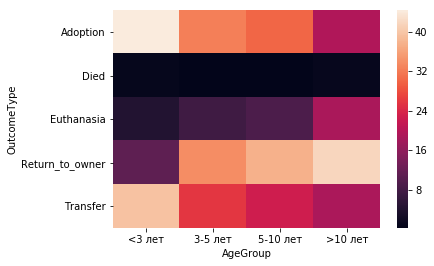

In [9]:
shelter_df['AgeGroup'] = shelter_df['AgeInYears'].apply(lambda a: 3 - ((a < 3) + (a < 5) + (a < 10)))

# print( 100 * shelter_df['AgeGroup'].value_counts(normalize = True) )

# По прежней технологии считаем относительное распределение по OutcomeType для каждой возратной группы
age_group_out_ratios = shelter_df.groupby(['OutcomeType', 'AgeGroup'])['AgeGroup'].count()
age_group_out_ratios = age_group_out_ratios.groupby(level=1).apply(lambda x: x / sum(x))
# В процентах
age_group_out_ratios_df = (age_group_out_ratios * 100).reset_index(name = '%')

# Сводная таблица с более выразительными именами колонок
age_group_out_ratios_pv = age_group_out_ratios_df.pivot_table(values='%', index='OutcomeType', columns='AgeGroup')
age_group_out_ratios_pv = age_group_out_ratios_pv.rename(lambda a: ['<3 лет','3-5 лет','5-10 лет','>10 лет'][a], axis='columns')

# Зависимость есть: маленьких больше забирают, взрослых чаще возвращают хозяевам
display(age_group_out_ratios_pv)
sns.heatmap(age_group_out_ratios_pv);

# 2. Tracks

## 2.1 xml

_Возможно, перепутал широту и долготу)_

In [10]:
root = ET.parse('data-405-2018-10-03.xml').getroot()

In [11]:
tracks = dict()
for elt in root:
    name = elt.find('Name')
    track = elt.find('Track')
    coord_list = [ coord.split(',') for coord in track.text.split(';') ]
    latt, long = list(zip(*[ (float(latt), float(long)) for long, latt in coord_list ]))
    tracks[name.text] = [latt, long]

pd.DataFrame.from_records([ (len(tracks[k][0]), len(tracks[k][1])) for k in tracks.keys() ], 
                          index = tracks.keys(), columns=['# Latt points', '# Long points'] ).head(10)

,# Latt points,# Long points
Маршрут № 014 по ЮВАО,341,341
Маршрут № 001 по ЮАО,1133,1133
Маршрут № 011 (В) по ЗАО,1016,1016
Маршрут № 004 (1) по ЮАО,320,320
Маршрут № 002 (2) по НАО,1505,1505
Маршрут № 009 (2) по ЮАО,1507,1507
Маршрут № 002 (А) по ЮАО,1506,1506
Маршрут № 003 по ЮАО,510,510
Маршрут № 005 по СЗАО,1538,1538
Маршрут № 004 (Б) 2 по ЮАО,1505,1505


## 2.1 visualisation

_На карте местности пока не смогу визуализировать, поэтому как-то так)_

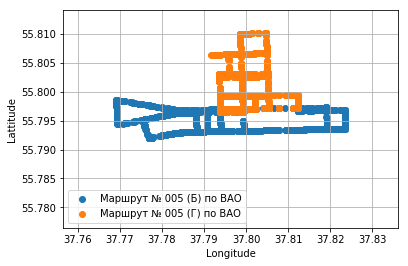

In [12]:
plt.grid()
plt.xlabel('Longitude')
plt.ylabel('Lattitude')

def scatter_plot(name):    
    plt.scatter(x=tracks[name][1], y=tracks[name][0], label=name)

scatter_plot('Маршрут № 005 (Б) по ВАО')
scatter_plot('Маршрут № 005 (Г) по ВАО')

plt.legend();

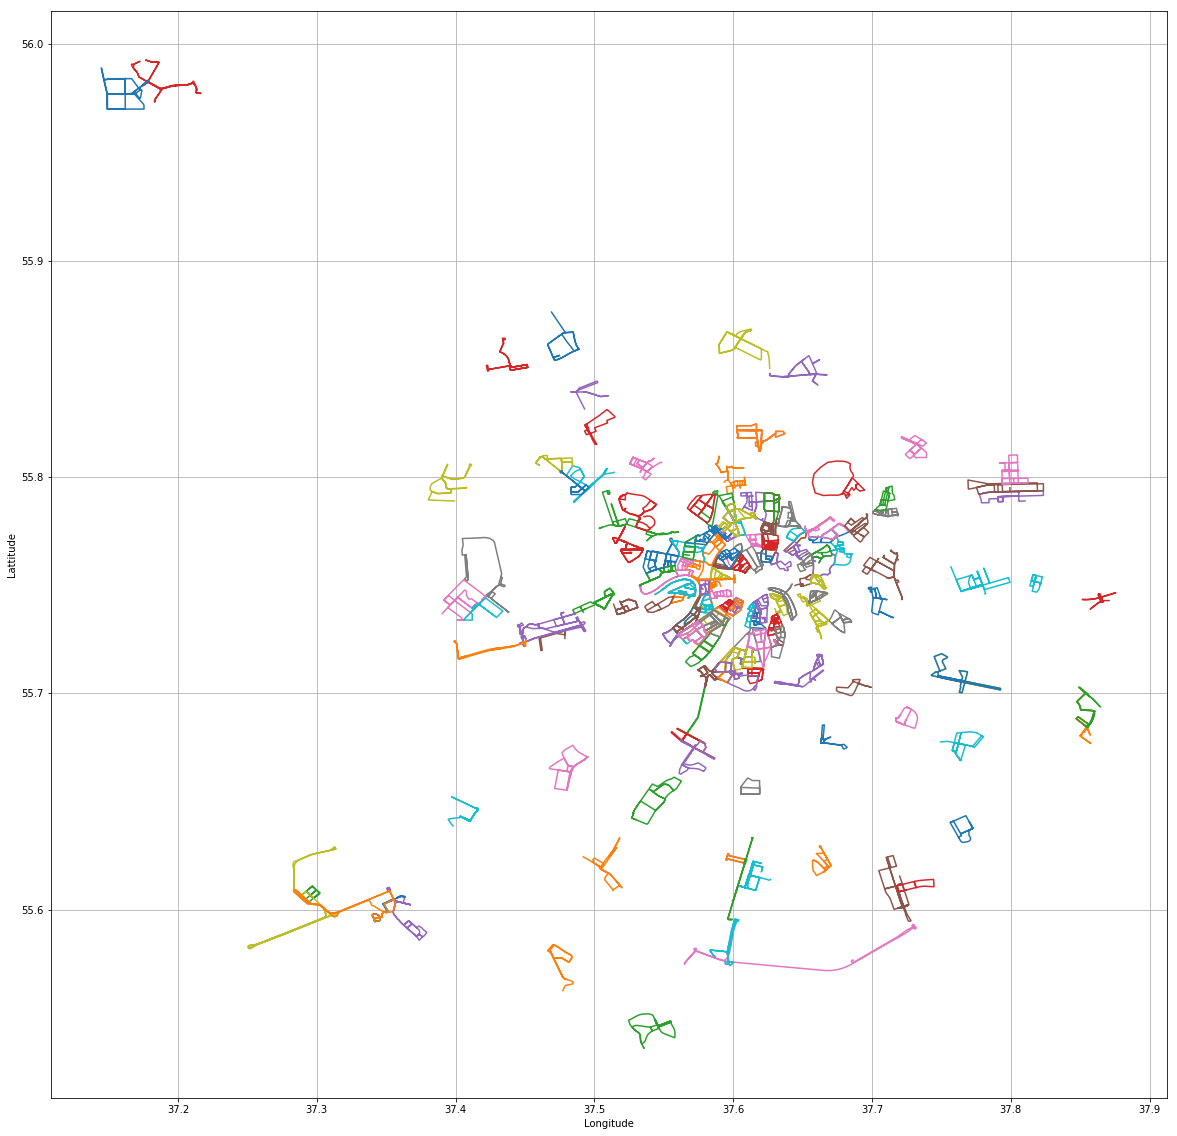

In [13]:
plt.figure(figsize=(20, 20))
plt.grid()
plt.xlabel('Longitude')
plt.ylabel('Lattitude')

for route in tracks.keys():
    plt.plot(tracks[route][1], tracks[route][0])